# Projeto D3-TOP

## 1. Descrição do problema

Em 2022 o Superior Tribunal de Justiça (STJ) passou a disponibilizar os dados de processos judiciais que tramitam naquela corte em um portal de dados abertos ([Notícia de 20/05/2022](https://www.stj.jus.br/sites/portalp/Paginas/Comunicacao/Noticias/20052022-Novo-Portal-de-Dados-Abertos-amplia-transparencia-de-acoes-realizadas-no-STJ.aspx)). Esse novo portal passou a disponibilizar dados que já estavam disponíveis publicamente na página web do STJ de maneira estruturada e acessível por máquina, sem a necessidade de realizar *web scraping*.

Dos dados disponíveis, existe um conjunto denominado "Íntegras de Decisões Terminativas e Acórdãos do Diário da Justiça". Neste repositório estão disponíveis decisões que terminam processos, seja indeferindo recursos à corte ou dando-lhes provimento monocraticamente, seja acórdãos de casos específicos.

Atualmente são disponibilizados como metadados vários elementos dos processos, como tipo, teor (Negando, Dando provimento, etc), assuntos vinculados, etc. Essas informações facilitam a busca e filtragem de dados no dataset. Essas informações são cadastradas manualmente pelos operadores do direito, sejam os advogados das partes, sejam os serventuários da justiça, e dependem da entrada manual dos dados.

O problema que se busca analisar e eventualmente solucionar com esse projeto é a utilização de técnicas de Processamento de Linguagem natural (*Natural Language Processing* - NLP) para verificar se é possível e com que exatidão prever os assuntos abordados nas decisões sem depender da interação humana.


## 2. Descrição da base de dados

Para esse projeto será utilizada a base de dados abertos do STJ, especificamente a base "*Íntegras de Decisões Terminativas e Acórdãos do Diário da Justiça*", disponível em https://dadosabertos.web.stj.jus.br/dataset/integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica.

A base de dados possui um dicionário (dicionariointegrasdecisoes.csv) com a descrição dos campos e seus tipos associados.

Nessa base de dados é disponibilizado, nos dias que existe publicação no diário oficial, um arquivo .zip. Referido arquivo possui um arquivos denominado metadados, em json, descrevendo:


| Campo | Tipo |Descrição ||---|---|---|
| SeqDocumento | Numérico | Identificador da decisão ou acórdão. Corresponde ao nome do arquivo TXT encontrado no ZIP, no qual consta o texto completo da decisão ou acórdão. |
| 
dataPublicacao  |Data | Data da publicação do documento no Diário da Justiça Eletrônico  | | 
tipoDocumento  |Texto | Informa se o documento é um acórdão ou uma decisão terminatia |.| |  
numeroRegistr o |Texto| Numero de registro do processo no qual foi proferido o Acórdão ou Decisão no Sistema d | |T|J|   
proces so |Texto | Sigla da classe processual seguida do número do processo naquel l|a| |s| se.
dataRecebime nto  |Data| Data que o processo foi recebd n|o| | | STJ.
dataDistribu ição  |Data| Data que o processo foidstr|i| |b| uído.
min istro |Texto | Nome do ministro relator do acórdão ou proferio da |d| |e| cisão. 
 recur s o|Texto|Indica o recurso interno sobre o qual foi proferida a decisão ou acórdão se houver. Quando nulo, indica que se refere ao proeso pr|i|n| cipa l . 
t eor|Texto|Pequeno texto que corresponde ao desfecho do julgamento. Ex. Concedendo, Denegando, Não Conhecendo etc. Disponível para acórdãos e deciõs mono|c|r| áticas. 
descricaoM o nocra t ica|Texto|Pequeno texto que corresponde à conclusão do julgado. Disponível apenas para deiões mon|o|c| ráticas.   
ass | tos|Texto|"Lista dos códigos CNJ dos assuntos relacionados ao processo separados por ';'.  O significado desses códigos estão disponíveis para download em https://dpj.cnj.jus.br/sgt/api/v1.0/assuntos.csv e para https://www.cnj.jus.br/sgt/consulta_publica_as |ntos.php. "




* Identificador do documento
* Data de publicação
* Tipo de documento (Acórdão ou decisão)
* Teor (Deferindo ou negando)
* Assunto vinculados

O identificador do documento é utilizado para identificar o arquivo .txt dentro do diretório compactado que contém o texto da decisão.

## 3. Objetivo científico associado ao problema

A utilização de técnicas de NLP tem objetivos científicos, especificamente: **a)** verificar o quanto os sistemas de NLP são capazes de realizar a classificação de textos jurídicos automaticamente, utilizando os dados já rotulados e **b)** Partir de classificações mais genéricas para mais específicas e, eventualmente, classificar as decisões em critérios mais específicos que os disponíveis atualmente.

## 4. Obtenção dos dados

### 4.1 Download dos dados em si
Os dados estão disponíveis no repositório de dados públicos do STJ pela API comum da CKAN. Inicialmente precisamos fazer o download dos dados.

In [170]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import urllib.request
#!pip install prettyprint
from pprint import pprint
import os
import re
import zipfile
import glob
from pytz import timezone
brtz = timezone('America/Sao_Paulo') #Ajusta a timezone para correção da hora no dataset

In [51]:
# Desativando os avisos para o notebook
#import warnings
#warnings.filterwarnings('')

In [4]:
#Função para exibir o resultado de uma request web com resposta em JSON em pretty print
def pprint_request(url):
    response = requests.get(url)
    data_url = json.loads(response.text)
    pprint(data_url)

In [19]:
#Segundo a documentação do STJ e CKAN, o acesso em API fica no endereço 'https://dadosabertos.web.stj.jus.br/api'
#Para acessar, segundo a documentação do CKAN, devemos usar o comando 'action/package_list'
pprint_request('https://dadosabertos.web.stj.jus.br/api/action/package_list')

{'help': 'https://dadosabertos.web.stj.jus.br/api/3/action/help_show?name=package_list',
 'result': ['espelhos-de-acordaos-corte-especial',
            'espelhos-de-acordaos-primeira-secao',
            'espelhos-de-acordaos-primeira-turma',
            'espelhos-de-acordaos-quarta-turma',
            'espelhos-de-acordaos-quinta-turma',
            'espelhos-de-acordaos-segunda-secao',
            'espelhos-de-acordaos-segunda-turma',
            'espelhos-de-acordaos-sexta-turma',
            'espelhos-de-acordaos-terceira-secao',
            'espelhos-de-acordaos-terceira-turma',
            'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica',
            'movimentacao-processual',
            'precedentes-qualificados'],
 'success': True}


In [17]:
# Os dados que buscamos está em 'integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica'.
# Segundo a documentação do CKAN, ele está disponível usando o comando '/action/package_show?id=' e colocando o pacote que se busca.
pprint_request('https://dadosabertos.web.stj.jus.br/api/action/package_show?id=integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica')

{'help': 'https://dadosabertos.web.stj.jus.br/api/3/action/help_show?name=package_show',
 'result': {'author': '',
            'author_email': '',
            'creator_user_id': '6b58f365-ed79-4267-890e-5baceedd6b3b',
            'extras': [],
            'groups': [{'description': 'Compreende os dados publicados no '
                                       'Diário da Justiça. Conforme exposto em '
                                       'nosso Plano de Dados Abertos, num '
                                       'primeiro momento estão disponíveis '
                                       'apenas as decisões terminativas e '
                                       'acórdãos publicados. Os demais dados, '
                                       'como as atas de distribuição e atos '
                                       'normativos, serão disponibilizados em '
                                       'momento futuro. ',
                        'display_name': 'Diário da Justiça Eletrônico',
 

Os dados que buscamos estão dentro de ```results\resources```. Dentro desse diretório cada elemento JSON representa uma unidade dos dados que buscamos.

Logo, precisamos obter uma lista desses URL para automatizar o download dos dados.

In [42]:
url_list = []
response_CKAN = requests.get('https://dadosabertos.web.stj.jus.br/api/action/package_show?id=integras-de-decisoes-terminativas-e-acordaos-do-diario-da-justica')
data_JSON = json.loads(response_CKAN.text)
for i in data_JSON['result']['resources']:
    url_list.append(i['url'])
url_list

['https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/0488e8aa-33a3-494d-86ef-17889a0155ee/download/dicionariointegrasdecisoes.csv',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/___',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/531fe446-1105-46d6-9ac0-a6fd56739286/download/metadados202202.json',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/b9687b6f-588a-49cb-a7fa-e4b21b835c66/download/___',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/06c2c424-7eec-4a32-bea3-e26c9ba4c7dd/download/metadados202203.json',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/55da875a-4cd7-40e8-9566-61ef3d7a399d/download/___',
 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd

In [45]:
#Vendo a lista de URLs, há um pequeno erro no dataset que não especificou o tipo de dados das entradas. Como são apenas 4 entradas antigas com erros, corrigiremos isso manualmente.
#url_list.index('https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/6f45c34b-a725-4d35-93f8-42a03ae55cdf/download/___')
url_list[1] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202202.zip'
url_list[3] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202203.zip'
url_list[5] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/202204.zip'
url_list[7] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/2b640cb2-cd3f-4737-999b-efece1196fbe/download/20220502.zip'
url_list[122] = 'https://dadosabertos.web.stj.jus.br/dataset/a2cd85cc-1391-4ebc-aeed-a45dd75a7987/resource/6f45c34b-a725-4d35-93f8-42a03ae55cdf/download/metadados20220818.json'

In [69]:
#Os arquivos .zip já contém uma cópia do arquivo de metadados. Para economizar na quantidade de download, vamos remover esses metadados da lista de downloads.
url_list = [url for url in url_list if not re.search(r'metadados', url)]

In [71]:
#Por último, iremos realizar o download dos dados e colocar na pasta original_data
for url in url_list:
    response = requests.get(url)
    if response.status_code == 200:
        filename = url.split('/')[-1] #Usa o nome do arquivo da URL
        with open('original_data//' + filename, "wb") as file:
            file.write(response.content)
        print(f"Download ok: {filename}")
    else:
        print(f"Erro no download de: {url}. Código de erro: {response.status_code}")

Download ok: dicionariointegrasdecisoes.csv
Download ok: 202202.zip
Download ok: 202203.zip
Download ok: 202204.zip
Download ok: 20220502.zip
Download ok: 20220503.zip
Download ok: 20220504.zip
Download ok: 20220505.zip
Download ok: 20220506.zip
Download ok: 20220509.zip
Download ok: 20220510.zip
Download ok: 20220511.zip
Download ok: 20220512.zip
Download ok: 20220513.zip
Download ok: 20220516.zip
Download ok: 20220517.zip
Download ok: 20220518.zip
Download ok: 20220519.zip
Download ok: 20220520.zip
Download ok: 20220523.zip
Download ok: 20220523.zip
Download ok: 20220524.zip
Download ok: 20220525.zip
Download ok: 20220526.zip
Download ok: 20220527.zip
Download ok: 20220530.zip
Download ok: 20220531.zip
Download ok: 20220601.zip
Download ok: 20220602.zip
Download ok: 20220603.zip
Download ok: 20220606.zip
Download ok: 20220607.zip
Download ok: 20220608.zip
Download ok: 20220609.zip
Download ok: 20220610.zip
Download ok: 20220613.zip
Download ok: 20220614.zip
Download ok: 20220615.zip


In [4]:
#Os dados foram obtidos dentro de arquivos .zip. Iremos desempacotar para processamento.
def unpack_zips(folder_path):
    for filename in os.listdir(folder_path): #Itera sobre os arquivos em uma pasta
        file_path = os.path.join(folder_path, filename)
        if zipfile.is_zipfile(file_path): #Verifica se o arquivo é .zip
            output_folder = os.path.join(folder_path, 'extracted', os.path.splitext(filename)[0]) # Create a new directory to store the extracted files
            os.makedirs(output_folder, exist_ok=True)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(output_folder) #Extrai o arquivo na pasta
                print(f"Arquivo {filename} extraído para {output_folder}")

In [5]:
unpack_zips('./original_data/')

Arquivo 202202.zip extraído para ./original_data/extracted\202202
Arquivo 202203.zip extraído para ./original_data/extracted\202203
Arquivo 202204.zip extraído para ./original_data/extracted\202204
Arquivo 20220502.zip extraído para ./original_data/extracted\20220502
Arquivo 20220503.zip extraído para ./original_data/extracted\20220503
Arquivo 20220504.zip extraído para ./original_data/extracted\20220504
Arquivo 20220505.zip extraído para ./original_data/extracted\20220505
Arquivo 20220506.zip extraído para ./original_data/extracted\20220506
Arquivo 20220509.zip extraído para ./original_data/extracted\20220509
Arquivo 20220510.zip extraído para ./original_data/extracted\20220510
Arquivo 20220511.zip extraído para ./original_data/extracted\20220511
Arquivo 20220512.zip extraído para ./original_data/extracted\20220512
Arquivo 20220513.zip extraído para ./original_data/extracted\20220513
Arquivo 20220516.zip extraído para ./original_data/extracted\20220516
Arquivo 20220517.zip extraído pa

### 4.2 Carregamento e preparação dos metadados

Junto com os arquivos .txt dos dados vem um arquivo ```metadados<data>json``` que deve seguir a estrutura discriminada no arquivo dicionariointegrasdecisoes.csv. Seguindo a descrição nesse arquivo a estrutura dos arquivos 'metadados' possuem o esquema definido no item 2. acima.

Nesse momento, criaremos o arquivo estruturando os metadados, vez que estes foram carregados em arquivos separados com cada entrada criada no repositório.


In [2]:
#Carregando lista de arquivos de metadados
def find_metadata_files(root_folder):
    files_list = []    
    for folder_path, _, file_names in os.walk(root_folder):
        for file_name in file_names:
            if 'metadados' in file_name and file_name.endswith('.json'):
                file_path = os.path.join(folder_path, file_name)
                files_list.append(file_path)

    return files_list
metadata_file_list = find_metadata_files('./original_data/extracted/')

In [3]:
#Carregando os dados json em um dataframe:
df = pd.read_json(metadata_file_list[0])
for i in metadata_file_list[1:]:
    df = pd.concat([df,pd.read_json(i)])

In [4]:
#Salvando o arquivo gerado em um arquivo .csv para fácil recuperação
df.to_csv('all_metadata.csv', index=False)

In [142]:
#Carregando os dados csv para continuar
df = pd.read_csv('all_metadata.csv')
df.head()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,1644458400000,ACÓRDÃO,202002151590,REsp 1890871,1598238000000,1598929200000,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
1,145620297,1645412400000,ACÓRDÃO,202103074377,HC 695900,1632279600000,1632279600000,SEBASTIÃO REIS JÚNIOR,NaN,Concedendo,NaN,3372;3372
2,139579332,1644890400000,ACÓRDÃO,202103073420,HC 695866,1632279600000,1632279600000,ANTONIO SALDANHA PALHEIRO,NaN,Concedendo,NaN,4355;4355;3608
3,141816757,1645758000000,ACÓRDÃO,202103076854,Rcl 42334,1632279600000,1632452400000,REYNALDO SOARES DA FONSECA,NaN,Concedendo,NaN,3608;3608
4,144148942,1645412400000,ACÓRDÃO,202103167750,HC 697730,1632884400000,1633057200000,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,Concedendo,NaN,3608;3608


In [143]:
df.drop_duplicates()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,1644458400000,ACÓRDÃO,202002151590,REsp 1890871,1598238000000,1598929200000,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
1,145620297,1645412400000,ACÓRDÃO,202103074377,HC 695900,1632279600000,1632279600000,SEBASTIÃO REIS JÚNIOR,NaN,Concedendo,NaN,3372;3372
2,139579332,1644890400000,ACÓRDÃO,202103073420,HC 695866,1632279600000,1632279600000,ANTONIO SALDANHA PALHEIRO,NaN,Concedendo,NaN,4355;4355;3608
3,141816757,1645758000000,ACÓRDÃO,202103076854,Rcl 42334,1632279600000,1632452400000,REYNALDO SOARES DA FONSECA,NaN,Concedendo,NaN,3608;3608
4,144148942,1645412400000,ACÓRDÃO,202103167750,HC 697730,1632884400000,1633057200000,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,Concedendo,NaN,3608;3608
...,...,...,...,...,...,...,...,...,...,...,...,...
871797,193030853,1686106800000,DECISÃO,202300677887,REsp 2058998,1678071600000,1680231600000,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671;13237
871798,193030865,1686106800000,DECISÃO,202300678355,REsp 2059001,1678071600000,1680231600000,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671
871799,192965821,1686106800000,DECISÃO,202300428571,REsp 2054346,1676253600000,1678417200000,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10735
871800,192925474,1686106800000,DECISÃO,202300438074,REsp 2052732,1676340000000,1677466800000,HUMBERTO MARTINS,NaN,NaN,Proferido despacho de mero expediente determin...,11806;11806


In [144]:
print(f'O dataset possui {df.shape[0]} entradas em {df.shape[1]} colunas/features.')

O dataset possui 871802 entradas em 12 colunas/features.


In [145]:
#df_backup = df.copy()

In [146]:
df.dtypes

seqDocumento             int64
dataPublicacao           int64
tipoDocumento           object
numeroRegistro           int64
processo                object
dataRecebimento          int64
dataDistribuicao         int64
ministro                object
recurso                 object
teor                    object
descricaoMonocratica    object
assuntos                object
dtype: object

In [147]:
#As colunas 'dataPublicacao', 'dataRecebimento' e 'dataDistribuicao' são de data, porém estão como int64. Para isso iremos ajustar os tipos de dados no pandas para datetime.
#De se observar que simplesmente usar o módulo 'to_datetime' deixa os horários errados pois têm que ser considerado o horário de Brasília mas ele simplemsmente converte para hora UTC.
#Por isso usaremos o tz_convert para converter no horário UTC-3 do Brasil.
df['dataPublicacao'] = pd.to_datetime(df['dataPublicacao'], unit='ms',utc=True)
df['dataRecebimento'] = pd.to_datetime(df['dataRecebimento'], unit='ms',utc=True)
df['dataDistribuicao'] = pd.to_datetime(df['dataDistribuicao'], unit='ms',utc=True)
df['dataPublicacao'] = df['dataPublicacao'].dt.tz_convert(brtz)
df['dataRecebimento'] = df['dataRecebimento'].dt.tz_convert(brtz)
df['dataDistribuicao'] = df['dataDistribuicao'].dt.tz_convert(brtz)
df.tail()

,seqDocumento,dataPublicacao,tipoDocumento,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
871797,193030853,2023-06-07 00:00:00-03:00,DECISÃO,202300677887,REsp 2058998,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671;13237
871798,193030865,2023-06-07 00:00:00-03:00,DECISÃO,202300678355,REsp 2059001,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671
871799,192965821,2023-06-07 00:00:00-03:00,DECISÃO,202300428571,REsp 2054346,2023-02-12 23:00:00-03:00,2023-03-10 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10735
871800,192925474,2023-06-07 00:00:00-03:00,DECISÃO,202300438074,REsp 2052732,2023-02-13 23:00:00-03:00,2023-02-27 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Proferido despacho de mero expediente determin...,11806;11806
871801,188631229,2023-06-07 00:00:00-03:00,DECISÃO,202204025519,CC 193921,2022-12-15 23:00:00-03:00,2022-12-18 23:00:00-03:00,HUMBERTO MARTINS,PETIÇÃO,NaN,Proferido despacho de mero expediente nada def...,4993;4993


In [148]:
for i in ['tipoDocumento','recurso','teor','descricaoMonocratica','assuntos']:
    print(f'Número de valores únicos no campo {i}: {df[i].nunique()}.')

Número de valores únicos no campo tipoDocumento: 2.
Número de valores únicos no campo recurso: 13.
Número de valores únicos no campo teor: 12.
Número de valores únicos no campo descricaoMonocratica: 179.
Número de valores únicos no campo assuntos: 94752.


In [149]:
#A variável tipoDocumento só possui dois valores diferentes, vamos checá-los para já fazer o encoding
df['tipoDocumento'].unique()

array(['ACÓRDÃO', 'DECISÃO'], dtype=object)

In [150]:
#Substituindo os valores e renomeando a coluna
df['tipoDocumento'] = df['tipoDocumento'].replace({'ACÓRDÃO': 1, 'DECISÃO': 0})
df = df.rename(columns={'tipoDocumento': 'isAcordao'})
df.tail()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
871797,193030853,2023-06-07 00:00:00-03:00,0,202300677887,REsp 2058998,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671;13237
871798,193030865,2023-06-07 00:00:00-03:00,0,202300678355,REsp 2059001,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671
871799,192965821,2023-06-07 00:00:00-03:00,0,202300428571,REsp 2054346,2023-02-12 23:00:00-03:00,2023-03-10 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10735
871800,192925474,2023-06-07 00:00:00-03:00,0,202300438074,REsp 2052732,2023-02-13 23:00:00-03:00,2023-02-27 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Proferido despacho de mero expediente determin...,11806;11806
871801,188631229,2023-06-07 00:00:00-03:00,0,202204025519,CC 193921,2022-12-15 23:00:00-03:00,2022-12-18 23:00:00-03:00,HUMBERTO MARTINS,PETIÇÃO,NaN,Proferido despacho de mero expediente nada def...,4993;4993


In [151]:
df.dtypes

seqDocumento                                        int64
dataPublicacao          datetime64[ns, America/Sao_Paulo]
isAcordao                                           int64
numeroRegistro                                      int64
processo                                           object
dataRecebimento         datetime64[ns, America/Sao_Paulo]
dataDistribuicao        datetime64[ns, America/Sao_Paulo]
ministro                                           object
recurso                                            object
teor                                               object
descricaoMonocratica                               object
assuntos                                           object
dtype: object

In [152]:
#A variável 'processo' 'é composta de um texto e um número, sendo interpretada pelo pandas como 'object'.
#Considernado que o início da descrição é a espécie do processo, iremos criar um campo denominado processoTipo, que vai manter a espécie recursal em uma variável distinta.
#Já o número permanece com identificador distinto do STJ.
df['especieProcesso'] = df['processo'].str.extract(r'(\D+)')
df['processo'] = df['processo'].str.replace(r'\D+', '',regex=True)
df = df.rename(columns={'processo': 'numProcessoSTJ'})
df.tail()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos,especieProcesso
871797,193030853,2023-06-07 00:00:00-03:00,0,202300677887,2058998,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671;13237,REsp
871798,193030865,2023-06-07 00:00:00-03:00,0,202300678355,2059001,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671,REsp
871799,192965821,2023-06-07 00:00:00-03:00,0,202300428571,2054346,2023-02-12 23:00:00-03:00,2023-03-10 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10735,REsp
871800,192925474,2023-06-07 00:00:00-03:00,0,202300438074,2052732,2023-02-13 23:00:00-03:00,2023-02-27 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Proferido despacho de mero expediente determin...,11806;11806,REsp
871801,188631229,2023-06-07 00:00:00-03:00,0,202204025519,193921,2022-12-15 23:00:00-03:00,2022-12-18 23:00:00-03:00,HUMBERTO MARTINS,PETIÇÃO,NaN,Proferido despacho de mero expediente nada def...,4993;4993,CC


In [153]:
df['especieProcesso'].unique()

array(['REsp ', 'HC ', 'Rcl ', 'APn ', 'SLS ', 'AREsp ', 'MS ', 'AR ',
       'PUIL ', 'CC ', 'RHC ', 'EREsp ', 'TP ', 'RMS ', 'EAREsp ', 'Pet ',
       'CR ', 'SS ', 'ExeMS ', 'Ag ', 'EAg ', 'RPV ', 'HDE ', 'RvCr ',
       'RO ', 'HD ', 'Prc ', 'IJ ', 'ExSusp ', 'MI ', 'MC ', 'EmbExeMS ',
       'SE ', 'ExImp ', 'ExeAR ', 'SIRDR ', 'EmbAc ', 'IDC ', 'ET ',
       'AC ', 'SEC ', 'EmbExeAr ', 'IF ', 'CAt ', 'Com ', 'TutAntAnt ',
       'TutCautAnt '], dtype=object)

In [154]:
df['especieProcesso'].nunique()

47

### 4.3 Filtragem das decisões

O dataset possui decisões de muitas classes processuais diversas, o que aumenta ainda mais o problema considerando os assuntos possíveis. Antes de filtrar uma classe para treinar, vamos verificar a distribuição dessas classes no dataset.

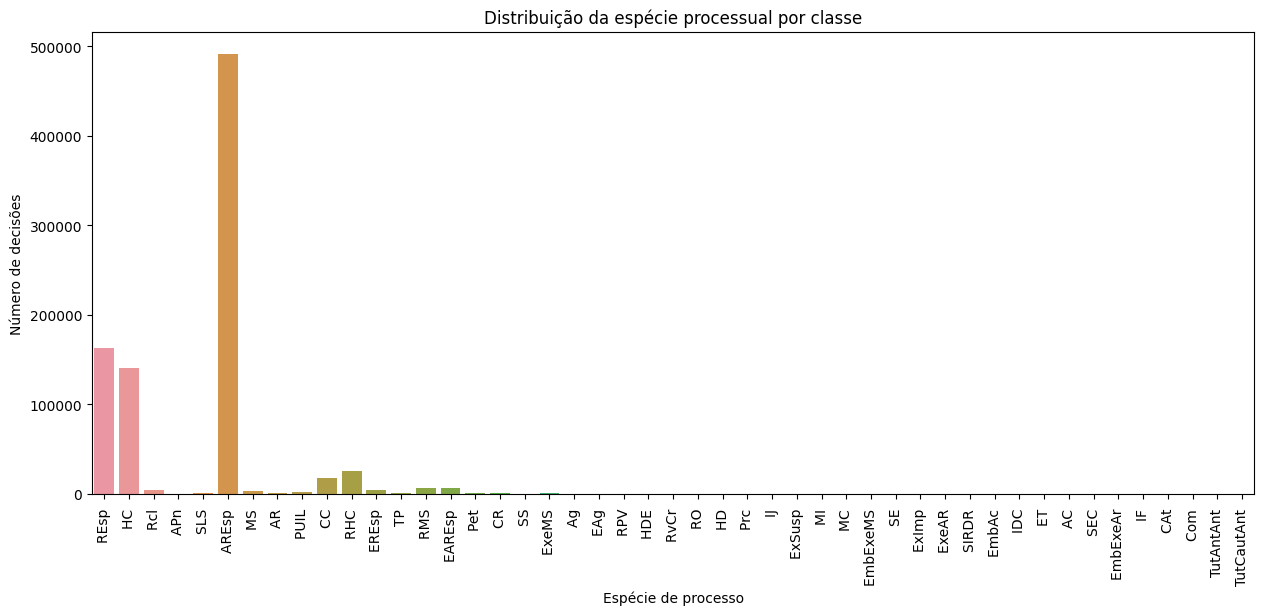

In [155]:
plt.figure(figsize=(15, 6))  # Adjust the width and height as needed
ax = sns.countplot(data=df, x='especieProcesso')
plt.xlabel('Espécie de processo')
plt.ylabel('Número de decisões')
plt.title('Distribuição da espécie processual por classe')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Como se observar, os Agravos em Recurso Especial (AREsp) são a classe predominante, seguida de Recursos Especiais (REsp) e *Habeas Corpus* (HC).

Considerando o número de decisões, apesar do AREsp ser predominante, iremos focar nos REsps por terem mais variabilidade de dados e número suficiente para uma filtragem.

In [156]:
mask = df['especieProcesso'] == 'REsp '
df_REsp = df[mask].copy()
df_REsp.drop('especieProcesso', axis=1, inplace=True)
df_REsp.head()

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,numProcessoSTJ,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos
0,144948780,2022-02-09 23:00:00-03:00,1,202002151590,1890871,2020-08-24 00:00:00-03:00,2020-09-01 00:00:00-03:00,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225
44,144998370,2022-02-13 23:00:00-03:00,1,202100936957,1959271,2021-03-30 00:00:00-03:00,2021-04-12 00:00:00-03:00,OG FERNANDES,NaN,Concedendo,NaN,10288;10288;10673;10673
60,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451
61,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451
62,140395973,2022-02-13 23:00:00-03:00,1,201401895544,1475609,2014-08-05 00:00:00-03:00,2014-08-22 00:00:00-03:00,RAUL ARAÚJO,AGRAVO INTERNO,Concedendo,NaN,10451


In [157]:
df_REsp.shape

(162544, 12)

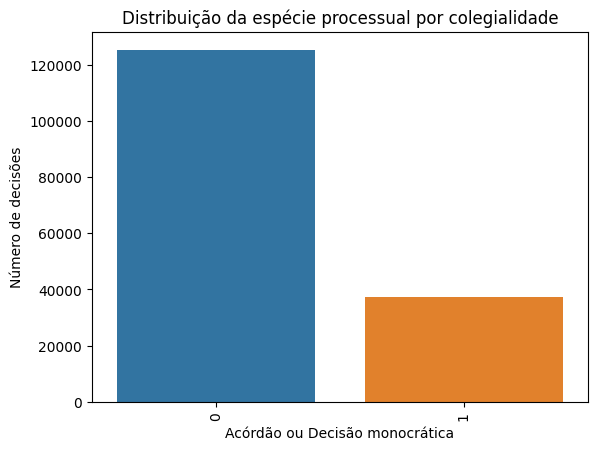

In [158]:
#plt.figure(figsize=(15, 6))
ax = sns.countplot(data=df_REsp, x='isAcordao')
plt.xlabel('Acórdão ou Decisão monocrática')
plt.ylabel('Número de decisões')
plt.title('Distribuição da espécie processual por colegialidade')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Observa-se que a maior parte das decisões são monocráticas, provavelmente concedendo ou negando em razão de jurisprudência consolidada.
Considerando-se que ainda é um número alto de decisões, iremos filtrar e selecionar apenas as decisões monocráticas (valor 0) para seguirmos na seleção de dados.

In [159]:
df_REsp = df_REsp.loc[df['isAcordao'] == 0].copy()
df_REsp.shape

(125264, 12)

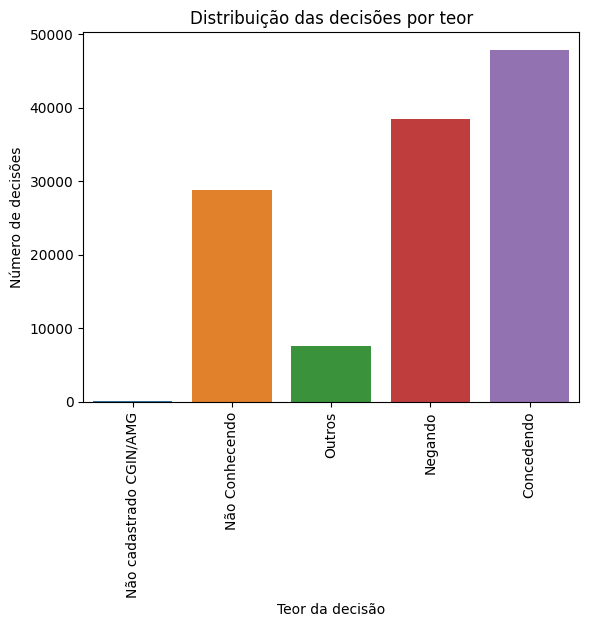

In [160]:
ax = sns.countplot(data=df_REsp, x='teor')
plt.xlabel('Teor da decisão')
plt.ylabel('Número de decisões')
plt.title('Distribuição das decisões por teor')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.show()

Como se observa, a maior parte das decisões é concedendo, negando ou não conhecendo o recurso.

Aqui já se extrai uma informação relevante para os operadores do direito: Uma vez que o recurso especial é admitido a chance de ser conhecido no mérito é maior do que se não admitido.

No que tange a esse trabalho, mesmo se limitando às decisões 'Concedendo' já temos um corpus bem relevante para treinamento, logo vamos focar nessa categoria.

In [161]:
df_REsp['teor'].unique()

array([nan, 'Não cadastrado CGIN/AMG', 'Não Conhecendo', 'Outros',
       'Negando', 'Concedendo'], dtype=object)

In [162]:
desired_value = 'Concedendo'
mask = df_REsp['teor'] == desired_value
df_REsp = df_REsp[mask].copy()
df_REsp.shape

(47896, 12)

In [164]:
df_REsp.to_csv('RESPs_todos_assuntos.csv', index=False)

In [166]:
df_REsp = pd.read_csv('RESPs_todos_assuntos.csv')

Por último, os assuntos precisam ser organizados. Esses assuntos estão disponíveis para consulta no [site do CNJ](https://www.cnj.jus.br/sgt/consulta_publica_assuntos.php), mas também são disponibilizados para download num arquivo .csv. Como essa tabela possui grande granularidade (mais de 4700 assuntos disponíveis), vamos agrupar decisões em dois grandes grupos: Direito Civil e Direito Penal, ignorando demais temas.
Para evitar que isso se tranforme em um problema multilabel, decisões que abranjam ao mesmo tempo Direito Civil e Direito Penal serão excluidas também.

In [171]:
#Baixando o arquivo de assuntos
urllib.request.urlretrieve('https://dpj.cnj.jus.br/sgt/api/v1.0/assuntos.csv', 'assuntos.csv')

('assuntos.csv', <http.client.HTTPMessage at 0x1e6f44fdc10>)

In [236]:
#Carregando o arquivo
assuntos = pd.read_csv('assuntos.csv', encoding='utf-8', delimiter=';')
assuntos.shape

(5358, 7)

In [237]:
#Removendo assuntos inativos
assuntos.drop((assuntos[assuntos['situacao'] == 'I'].index), inplace = True)
assuntos.shape

(4726, 7)

In [238]:
#Mostrando códigos de direito civil
codigos_civil = assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['codigo'].tolist()
codigos_civil += assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['cod_filhos'].tolist()
codigos_civil += assuntos[assuntos['descricao'] == 'DIREITO CIVIL']['cod_filhos_ativos'].tolist()
assuntos[assuntos['descricao'] == 'DIREITO CIVIL']

,situacao,dat_alteracao,codigo,descricao,cod_pai,cod_filhos,cod_filhos_ativos
508,A,NaN,899,DIREITO CIVIL,NaN,"5626,5754,7673,7681,7947,9616,9981,10431,10432...","5626,5754,7673,7681,7947,9616,9981,10431,10432..."


In [239]:
#Mostrando códigos de direito penal
codigos_penal = assuntos[assuntos['descricao'] == 'DIREITO PENAL']['codigo'].tolist()
codigos_penal += assuntos[assuntos['descricao'] == 'DIREITO PENAL']['cod_filhos'].tolist()
codigos_penal += assuntos[assuntos['descricao'] == 'DIREITO PENAL']['cod_filhos_ativos'].tolist()
assuntos[assuntos['descricao'] == 'DIREITO PENAL']

,situacao,dat_alteracao,codigo,descricao,cod_pai,cod_filhos,cod_filhos_ativos
506,A,NaN,287,DIREITO PENAL,NaN,"3369,3385,3388,3393,3394,3400,3405,3407,3412,3...","3369,3385,3388,3393,3394,3400,3405,3407,3412,3..."


In [240]:
#Aninhando as listas para desempacotar
codigos_civil[1] = codigos_civil[1].split(',')
codigos_civil[2] = codigos_civil[2].split(',')
codigos_penal[1] = codigos_penal[1].split(',')
codigos_penal[2] = codigos_penal[2].split(',')

In [244]:
#Função para desempacotar lista aninhada
def unpack_and_convert(nested_list):
    result = []
    for item in nested_list:
        if isinstance(item, list):
            result.extend(unpack_and_convert(item))
        else:
            result.append(int(item))
    return result

In [255]:
#Desempacota e itera sobre os números, evitando números repetidos
codigos_civil = list(set(unpack_and_convert(codigos_civil)))
codigos_penal = list(set(unpack_and_convert(codigos_penal)))

In [256]:
print(codigos_civil)

[6238, 6239, 12383, 10431, 10432, 10433, 10434, 10435, 10436, 10437, 10439, 10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458, 10459, 10460, 10461, 10462, 10463, 10464, 10465, 10466, 10467, 10468, 10469, 10470, 10480, 10481, 10482, 10483, 10484, 10485, 10486, 10487, 10488, 10489, 10490, 10491, 10492, 10493, 10494, 10495, 10496, 10499, 10500, 10501, 10577, 10582, 10585, 10586, 10588, 10590, 10592, 10595, 14694, 14735, 14740, 14743, 4654, 4656, 4660, 4670, 14915, 14916, 14917, 14918, 14919, 14920, 14921, 14922, 14923, 14924, 4680, 4701, 4703, 4706, 10855, 4718, 4728, 12935, 12937, 10924, 12980, 10936, 4794, 10948, 4805, 15046, 15047, 4813, 4839, 4840, 4841, 4842, 4843, 4846, 15087, 15088, 4847, 4854, 11000, 11001, 13055, 4897, 4899, 4902, 4904, 4905, 4907, 4909, 4910, 13124, 15173, 4933, 4934, 4935, 4939, 4940, 4942, 4943, 13136, 15189, 4949, 4951, 4957, 4960, 4961, 4962, 4963, 4964, 13153, 4968, 4969, 4970

In [247]:
print(codigos_penal)

[287, 3369, 3385, 3388, 3393, 3394, 3400, 3405, 3407, 3412, 3415, 3442, 3445, 3457, 3463, 3472, 3491, 3520, 3523, 3547, 3603, 3692, 5555, 5865, 5872, 5873, 5874, 5875, 10620, 10949, 10950, 10951, 10952, 11414, 12217, 12333, 12342, 12588, 15147, 15169, 15174, 3370, 3371, 3372, 3373, 3375, 10915, 12091, 12130, 15177, 10917, 10918, 10919, 3386, 3387, 5556, 5557, 5558, 5560, 14943, 12194, 12195, 3389, 3390, 3391, 3392, 5911, 10508, 10509, 14690, 3395, 3396, 3397, 12542, 12543, 12544, 14100, 14101, 14102, 14103, 14104, 14105, 14106, 14107, 15126, 3401, 3402, 3403, 3404, 14659, 14665, 14684, 14942, 14660, 14661, 14662, 14663, 14664, 14666, 14667, 14668, 14669, 14670, 3406, 3408, 3409, 3410, 3411, 3413, 3414, 11978, 3416, 3417, 3418, 3419, 3420, 3421, 3422, 3423, 3424, 3425, 3426, 3427, 3428, 3429, 3430, 3431, 3432, 3433, 3434, 3435, 3436, 3437, 5564, 5565, 5566, 5567, 5568, 5569, 5570, 5571, 5572, 5573, 5835, 5836, 5837, 5838, 5839, 5840, 5841, 5842, 5843, 5844, 5845, 5846, 5847, 11959, 1469

In [257]:
#Verificando se por acaso alguma alteração deixou algum assunto em comum 
set1 = set(codigos_civil)
set2 = set(codigos_penal)
print(f'Número de assuntos em comum entre o conjunto de direito civil e o de direito penal: {len(set1.intersection(set2))}.')

Número de assuntos em comum entre o conjunto de direito civil e o de direito penal: 0.


In [264]:
#Criando uma função para iterar sobre o campo 'assuntos' e gerar uma lista com os assuntos nele contidos
def listaAssuntos(campo):
    assunto = campo.split(';')
    list_assuntos = set(assunto)
    return list(list_assuntos)

In [277]:
#Aplicando a função acima ao dataset para permitir a classificação por assuntos
df_REsp['assuntos'] = df_REsp['assuntos'].apply(listaAssuntos)

In [278]:
df_REsp['assuntos']

0                          [10395]
1                    [10621, 3608]
2             [10621, 3548, 10628]
3        [9163, 11806, 4960, 9607]
4                          [10318]
                   ...            
47891                 [9163, 6017]
47892    [9163, 5952, 12963, 6017]
47893                 [9163, 6017]
47894          [5986, 13250, 6017]
47895           [7942, 3608, 7792]
Name: assuntos, Length: 47896, dtype: object

In [293]:
lista_teste = df_REsp_teste['assuntos'].to_list()

In [279]:
df_REsp_teste = df_REsp.copy()

In [292]:
df_REsp_teste.to_csv('teste_set.csv')

In [299]:
df_REsp_teste['assuntoCivil'] = df_REsp_teste['assuntos'].apply(lambda x: 1 if any(item in x for item in codigos_civil) else 0)

In [300]:
df_REsp_teste['assuntoCivil'].sum()

0

In [286]:
df_REsp_teste['assuntoCivil'].sum()

0

In [287]:
codigos_civil

[6238,
 6239,
 12383,
 10431,
 10432,
 10433,
 10434,
 10435,
 10436,
 10437,
 10439,
 10440,
 10441,
 10442,
 10443,
 10444,
 10445,
 10446,
 10447,
 10448,
 10449,
 10450,
 10451,
 10452,
 10453,
 10454,
 10455,
 10456,
 10457,
 10458,
 10459,
 10460,
 10461,
 10462,
 10463,
 10464,
 10465,
 10466,
 10467,
 10468,
 10469,
 10470,
 10480,
 10481,
 10482,
 10483,
 10484,
 10485,
 10486,
 10487,
 10488,
 10489,
 10490,
 10491,
 10492,
 10493,
 10494,
 10495,
 10496,
 10499,
 10500,
 10501,
 10577,
 10582,
 10585,
 10586,
 10588,
 10590,
 10592,
 10595,
 14694,
 14735,
 14740,
 14743,
 4654,
 4656,
 4660,
 4670,
 14915,
 14916,
 14917,
 14918,
 14919,
 14920,
 14921,
 14922,
 14923,
 14924,
 4680,
 4701,
 4703,
 4706,
 10855,
 4718,
 4728,
 12935,
 12937,
 10924,
 12980,
 10936,
 4794,
 10948,
 4805,
 15046,
 15047,
 4813,
 4839,
 4840,
 4841,
 4842,
 4843,
 4846,
 15087,
 15088,
 4847,
 4854,
 11000,
 11001,
 13055,
 4897,
 4899,
 4902,
 4904,
 4905,
 4907,
 4909,
 4910,
 13124,
 15173,

In [269]:
df_REsp_teste['assuntos'] = df_REsp_teste['assuntos'].apply(listaAssuntos)

In [276]:
df_REsp_teste['assuntos']

0                          [10395]
1                    [10621, 3608]
2             [10621, 3548, 10628]
3        [9163, 11806, 4960, 9607]
4                          [10318]
                   ...            
47891                 [9163, 6017]
47892    [9163, 5952, 12963, 6017]
47893                 [9163, 6017]
47894          [5986, 13250, 6017]
47895           [7942, 3608, 7792]
Name: assuntos, Length: 47896, dtype: object

In [66]:
df_test['classeProcesso'] = df_test['processo'].str.extract(r'(\D+)')

In [67]:
df_test

,seqDocumento,dataPublicacao,isAcordao,numeroRegistro,processo,dataRecebimento,dataDistribuicao,ministro,recurso,teor,descricaoMonocratica,assuntos,classeProcesso
0,144948780,2022-02-09 23:00:00-03:00,1,202002151590,REsp 1890871,2020-08-24 00:00:00-03:00,2020-09-01 00:00:00-03:00,ASSUSETE MAGALHÃES,NaN,Concedendo,NaN,10254;10225;10254;10225,REsp
1,145620297,2022-02-21 00:00:00-03:00,1,202103074377,HC 695900,2021-09-22 00:00:00-03:00,2021-09-22 00:00:00-03:00,SEBASTIÃO REIS JÚNIOR,NaN,Concedendo,NaN,3372;3372,HC
2,139579332,2022-02-14 23:00:00-03:00,1,202103073420,HC 695866,2021-09-22 00:00:00-03:00,2021-09-22 00:00:00-03:00,ANTONIO SALDANHA PALHEIRO,NaN,Concedendo,NaN,4355;4355;3608,HC
3,141816757,2022-02-25 00:00:00-03:00,1,202103076854,Rcl 42334,2021-09-22 00:00:00-03:00,2021-09-24 00:00:00-03:00,REYNALDO SOARES DA FONSECA,NaN,Concedendo,NaN,3608;3608,Rcl
4,144148942,2022-02-21 00:00:00-03:00,1,202103167750,HC 697730,2021-09-29 00:00:00-03:00,2021-10-01 00:00:00-03:00,OLINDO MENEZES (DESEMBARGADOR CONVOCADO DO TRF...,NaN,Concedendo,NaN,3608;3608,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871797,193030853,2023-06-07 00:00:00-03:00,0,202300677887,REsp 2058998,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671;13237,REsp
871798,193030865,2023-06-07 00:00:00-03:00,0,202300678355,REsp 2059001,2023-03-06 00:00:00-03:00,2023-03-31 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10671,REsp
871799,192965821,2023-06-07 00:00:00-03:00,0,202300428571,REsp 2054346,2023-02-12 23:00:00-03:00,2023-03-10 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Processo Suspenso ou Sobrestado por Conflito d...,4847;4847;10588;10735,REsp
871800,192925474,2023-06-07 00:00:00-03:00,0,202300438074,REsp 2052732,2023-02-13 23:00:00-03:00,2023-02-27 00:00:00-03:00,HUMBERTO MARTINS,NaN,NaN,Proferido despacho de mero expediente determin...,11806;11806,REsp


In [ ]:
#Carregando os dados json em um dataframe:
df = pd_
def load_json(filepath):
    with open(filepath, encoding='utf-8') as file:
    pandas_df = pd.read_json

In [ ]:
#Criando um dataframe em pandas com os metadados dos arquivos
list_of_dictionaries = [...]  # Your list of dictionaries

for dictionary in list_of_dictionaries:
    # Create a DataFrame for the current dictionary
    new_dataframe = pd.DataFrame(dictionary)

    # Append the new DataFrame to the existing DataFrame
    existing_dataframe = existing_dataframe.append(new_dataframe, ignore_index=True)

In [30]:
metadata_file_list

['./original_data/extracted/202202\\metadadosPublicacao202202.json',
 './original_data/extracted/202203\\metadadosPublicacao202202.json',
 './original_data/extracted/202204\\metadadosPublicacao202202.json',
 './original_data/extracted/20220502\\metadadosPublicacao202202.json',
 './original_data/extracted/20220503\\metadadosPublicacao20220503.json',
 './original_data/extracted/20220504\\metadadosPublicacao20220504.json',
 './original_data/extracted/20220505\\metadadosPublicacao20220505.json',
 './original_data/extracted/20220506\\metadadosPublicacao20220506.json',
 './original_data/extracted/20220509\\metadadosPublicacao20220509.json',
 './original_data/extracted/20220510\\metadadosPublicacao20220510.json',
 './original_data/extracted/20220511\\metadadosPublicacao20220511.json',
 './original_data/extracted/20220512\\metadadosPublicacao20220512.json',
 './original_data/extracted/20220513\\metadadosPublicacao20220513.json',
 './original_data/extracted/20220516\\metadadosPublicacao20220516

In [ ]:
testeval 

In [ ]:
Metadado

In [14]:
json_test = None

In [16]:
with open('./original_data/extracted/20230607/metadados20230607.json') as file:
    json_test = json.loads(str(file)[1:-1])

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [17]:
json.load('./original_data/extracted/20230607/metadados20230607.json')

AttributeError: 'str' object has no attribute 'read'

In [6]:
#Usando o pacote jsonschema para verificar se os metadados seguem o mesmo esquema/estrutura


In [ ]:
#Os dados foram obtidos dentro de arquivos .zip. Iremos desempacotar para processamento.
def unpack_zips(caminho):
    output_folder = os.path.join(folder_path, 'extracted') # Create a new directory to store the extracted files
    os.makedirs(output_folder, exist_ok=True)


def unpack_zips(folder_path):
    # Iterate over all the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a ZIP file
        if zipfile.is_zipfile(file_path):
            # Create a new directory to store the extracted files
            output_folder = os.path.join(folder_path, os.path.splitext(filename)[0])
            os.makedirs(output_folder, exist_ok=True)

            # Open the ZIP file
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents of the ZIP file to the output folder
                zip_ref.extractall(output_folder)
                print(f"Extracted contents of {filename} to {output_folder}")



    
    # Iterate over all the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a ZIP file
        if zipfile.is_zipfile(file_path):
            # Open the ZIP file
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents of the ZIP file to the output folder
                zip_ref.extractall(output_folder)
                print(f"Extracted contents of {filename} to {output_folder}")


In [76]:
def unpack_zips(folder_path):
    # Create a new directory to store the extracted files
    output_folder = os.path.join(folder_path, 'extracted')
    os.makedirs(output_folder, exist_ok=True)

    # Iterate over all the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a ZIP file
        if zipfile.is_zipfile(file_path):
            # Open the ZIP file
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # Extract all the contents of the ZIP file to the output folder
                zip_ref.extractall(output_folder)
                print(f"Extracted contents of {filename} to {output_folder}")

In [77]:
unpack_zips('./original_data/')

Extracted contents of 202202.zip to ./original_data/extracted
Extracted contents of 202203.zip to ./original_data/extracted
Extracted contents of 202204.zip to ./original_data/extracted
Extracted contents of 20220502.zip to ./original_data/extracted
Extracted contents of 20220503.zip to ./original_data/extracted
Extracted contents of 20220504.zip to ./original_data/extracted
Extracted contents of 20220505.zip to ./original_data/extracted
Extracted contents of 20220506.zip to ./original_data/extracted
Extracted contents of 20220509.zip to ./original_data/extracted
Extracted contents of 20220510.zip to ./original_data/extracted
Extracted contents of 20220511.zip to ./original_data/extracted
Extracted contents of 20220512.zip to ./original_data/extracted
Extracted contents of 20220513.zip to ./original_data/extracted
Extracted contents of 20220516.zip to ./original_data/extracted
Extracted contents of 20220517.zip to ./original_data/extracted
Extracted contents of 20220518.zip to ./origin

>> TO AQUI <<

In [ ]:
#Com a l

In [39]:
with open('my_list.txt', 'w') as file:
    # Iterate over the list and write each element to a new line in the file
    for item in url_list:
        file.write(str(item) + '\n')


In [52]:
def get_dest_file_size(url):
    response = requests.head(url)
    size = response.headers.get("content-length", None)
    if size:
        return int(size)
    else:
        pass

In [53]:
for i in url_list[:3]:
    get_dest_file_size(i)

In [67]:
size

3142247018

In [66]:
size = 0
for i in url_list:
    val = get_dest_file_size(i)
    print(f'Arquivo: {i.split("/")[-1]} Tamanho: {val//1024}')
    size += val

Arquivo: dicionariointegrasdecisoes.csv Tamanho: 1
Arquivo: 202202.zip Tamanho: 222171
Arquivo: 202203.zip Tamanho: 222171
Arquivo: 202204.zip Tamanho: 222171
Arquivo: 20220502.zip Tamanho: 222171
Arquivo: 20220503.zip Tamanho: 17236
Arquivo: 20220504.zip Tamanho: 8087
Arquivo: 20220505.zip Tamanho: 10468
Arquivo: 20220506.zip Tamanho: 8707
Arquivo: 20220509.zip Tamanho: 8256
Arquivo: 20220510.zip Tamanho: 6701
Arquivo: 20220511.zip Tamanho: 10008
Arquivo: 20220512.zip Tamanho: 12264
Arquivo: 20220513.zip Tamanho: 8436
Arquivo: 20220516.zip Tamanho: 8556
Arquivo: 20220517.zip Tamanho: 9642
Arquivo: 20220518.zip Tamanho: 6446
Arquivo: 20220519.zip Tamanho: 14845
Arquivo: 20220520.zip Tamanho: 7689
Arquivo: 20220523.zip Tamanho: 7868
Arquivo: 20220523.zip Tamanho: 7868
Arquivo: 20220524.zip Tamanho: 9630
Arquivo: 20220525.zip Tamanho: 12999
Arquivo: 20220526.zip Tamanho: 10121
Arquivo: 20220527.zip Tamanho: 12800
Arquivo: 20220530.zip Tamanho: 10299
Arquivo: 20220531.zip Tamanho: 11031
A

Baixando dados CKAN
***

MUDAR ESSA PARTE PARA BAIXO

## 4.1 Preparando a tabela geral de assuntos judiciais

Os dados disponíveis no CNJ são indicados pelo código do assunto, disponíveis no site https://www.cnj.jus.br/sgt/versoes.php?tipo_tabela=A. Esses assuntos vem organizados em um arquivo do excel representando a hierarquia 




In [16]:
import pandas as pd


In [ ]:
#Organizando a tabela de assuntos judiciais





In [2]:
import json
import spacy
import re
nlp =  spacy.load('pt_core_news_sm')

In [3]:
#Carregando os metadados do arquivo .json
with open('./data/test/metadados.json', 'r', encoding="utf8") as f:
    json_data = f.read()
metadados = json.loads(json_data)

In [6]:
#Criando dicionário de metadados indexado pelo nome da entrada
metadados_dict = {}
for entrada in metadados:
    dados_json = metadados[entrada]

TypeError: list indices must be integers or slices, not dict

In [8]:
documento = dict(metadados[0])['seqDocumento']

In [12]:
#preprocessando texto
with open('./data/test/20230510/'+ str(documento) + '.txt', 'r', encoding="utf8") as file:
    text = file.read()
print(text)

EMENTA
AGRAVO INTERNO NO AGRAVO EM RECURSO ESPECIAL. DECISÃO DA PRESIDÊNCIA RECONSIDERADA. DIREITO EMPRESARIAL. LIQUIDAÇÃO EXTRAJUDICIAL. PEDIDO DE CONVOLAÇÃO EM LIQUIDAÇÃO ORDINÁRIA INDEFERIDO NA ORIGEM. AUSÊNCIA DE PREENCHIMENTO DOS REQUISITOS. NEGATIVA DE PRESTAÇÃO JURISDICIONAL. NÃO OCORRÊNCIA. VIOLAÇÃO DO ART. 19 DA LEI 6.024/74. FUNDAMENTOS DO ACÓRDÃO RECORRIDO NÃO IMPUGNADOS. RAZÕES RECURSAIS DISSOCIADAS DOS FUNDAMENTOS DO JULGADO ATACADO. APLICAÇÃO DAS SÚMULAS 283 E 284 DO STF. REVISÃO. IMPOSSIBILIDADE. REEXAME DE PROVA. SÚMULA 7/STJ. AGRAVO INTERNO PROVIDO. DECISÃO RECONSIDERADA. AGRAVO CONHECIDO PARA NÃO CONHECER DO RECURSO ESPECIAL.
1. Não se verifica a alegada violação ao art. 1.022 do CPC/2015, na medida em que a eg. Corte de origem dirimiu, fundamentadamente, a questão que lhe foi submetida, não sendo possível confundir julgamento desfavorável, como no caso, com negativa de prestação jurisdicional ou ausência de fundamentação.
2. A ausência de impugnação, nas razões do re

In [13]:
text = re.sub('<br>', ' ', text)
text = re.sub('[\\n\\t]',' ', text)
text = re.sub('\s{2,}','', text)
text = re.sub('[^\w\s]','', text)

In [14]:
text

'EMENTA AGRAVO INTERNO NO AGRAVO EM RECURSO ESPECIAL DECISÃO DA PRESIDÊNCIA RECONSIDERADA DIREITO EMPRESARIAL LIQUIDAÇÃO EXTRAJUDICIAL PEDIDO DE CONVOLAÇÃO EM LIQUIDAÇÃO ORDINÁRIA INDEFERIDO NA ORIGEM AUSÊNCIA DE PREENCHIMENTO DOS REQUISITOS NEGATIVA DE PRESTAÇÃO JURISDICIONAL NÃO OCORRÊNCIA VIOLAÇÃO DO ART 19 DA LEI 602474 FUNDAMENTOS DO ACÓRDÃO RECORRIDO NÃO IMPUGNADOS RAZÕES RECURSAIS DISSOCIADAS DOS FUNDAMENTOS DO JULGADO ATACADO APLICAÇÃO DAS SÚMULAS 283 E 284 DO STF REVISÃO IMPOSSIBILIDADE REEXAME DE PROVA SÚMULA 7STJ AGRAVO INTERNO PROVIDO DECISÃO RECONSIDERADA AGRAVO CONHECIDO PARA NÃO CONHECER DO RECURSO ESPECIAL 1 Não se verifica a alegada violação ao art 1022 do CPC2015 na medida em que a eg Corte de origem dirimiu fundamentadamente a questão que lhe foi submetida não sendo possível confundir julgamento desfavorável como no caso com negativa de prestação jurisdicional ou ausência de fundamentação 2 A ausência de impugnação nas razões do recurso especial de fundamento autônom

In [15]:
doc = nlp(text)

hp_sentences_spacy = [sent.text for sent in doc.sents]

for i, sentence in enumerate(hp_sentences_spacy):
    print(f'{i:02d} - {sentence}')

00 - EMENTA AGRAVO INTERNO NO AGRAVO EM RECURSO ESPECIAL DECISÃO DA PRESIDÊNCIA
01 - RECONSIDERADA
02 - DIREITO EMPRESARIAL
03 - LIQUIDAÇÃO EXTRAJUDICIAL PEDIDO DE CONVOLAÇÃO EM LIQUIDAÇÃO ORDINÁRIA INDEFERIDO NA ORIGEM AUSÊNCIA DE PREENCHIMENTO DOS REQUISITOS NEGATIVA DE PRESTAÇÃO JURISDICIONAL NÃO OCORRÊNCIA VIOLAÇÃO DO ART 19 DA LEI 602474 FUNDAMENTOS DO ACÓRDÃO RECORRIDO NÃO IMPUGNADOS
04 - RAZÕES RECURSAIS DISSOCIADAS DOS FUNDAMENTOS DO JULGADO ATACADO
05 - APLICAÇÃO
06 - DAS SÚMULAS 283
07 - E 284 DO STF REVISÃO IMPOSSIBILIDADE REEXAME DE PROVA SÚMULA 7STJ
08 - AGRAVO INTERNO PROVIDO
09 - DECISÃO RECONSIDERADA AGRAVO
10 - CONHECIDO PARA NÃO CONHECER DO RECURSO ESPECIAL 1
11 - Não se verifica a alegada violação ao art 1022 do CPC2015 na medida em que
12 - a eg Corte de origem dirimiu fundamentadamente a questão que lhe foi submetida não sendo possível confundir julgamento desfavorável como no caso com negativa de prestação jurisdicional ou ausência de fundamentação 2
13 - A ausênc

In [ ]:
# remover stopwords
